# LAB 2

Loading sample code...

1. Necessary imports

In [33]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

from PIL import Image
from scipy.ndimage import filters
from scipy.signal import medfilt2d
import numpy as np
import matplotlib.pyplot as plt
import math as math
import glob
import os
import sys

sys.path.append("../../p1/code") # set the path for visualPercepUtils.py
import visualPercepUtils as vpu

2. Defining filter and test methods

In [34]:

# -----------------------
# Salt & pepper noise
# -----------------------

def addSPNoise(im, percent):
    # Now, im is a PIL image (not a NumPy array)
    # percent is in range 0-100 (%)

    # convert image it to numpy 2D array and flatten it
    im_np = np.array(im)
    im_shape = im_np.shape  # keep shape for later use (*)
    im_vec = im_np.flatten()  # this is a 1D array # https://www.geeksforgeeks.org/differences-flatten-ravel-numpy/

    # generate random locations
    N = im_vec.shape[0]  # number of pixels
    m = int(math.floor(percent * N / 100.0)) # number of pixels corresponding to the given percentage
    locs = np.random.randint(0, N, m)  # generate m random positions in the 1D array (index 0 to N-1)

    # generate m random S/P values (salt and pepper in the same proportion)
    s_or_p = np.random.randint(0, 2, m)  # 2 random values (0=salt and 1=pepper)

    # set the S/P values in the random locations
    im_vec[locs] = 255 * s_or_p  # values after the multiplication will be either 0 or 255

    # turn the 1D array into the original 2D image
    im2 = im_vec.reshape(im_shape) # (*) here is where we use the shape that we saved earlier

    # convert Numpy array im2 back to a PIL Image and return it
    return Image.fromarray(im2)


def testSandPNoise(im, percents):
    imgs = []
    for percent in percents:
        imgs.append(addSPNoise(im, percent))
    return imgs


# -----------------
# Gaussian noise
# -----------------

def addGaussianNoise(im, sd=5):
    return im + np.random.normal(loc=0, scale=sd, size=im.shape)

def testGaussianNoise(im, sigmas):
    imgs = []
    for sigma in sigmas:
        print('testing sigma:', sigma)
        imgs.append(addGaussianNoise(im, sigma))
        print(len(imgs))
    return imgs


# -------------------------
# Average (or mean) filter
# -------------------------

def averageFilter(im, filterSize):
    mask = np.ones((filterSize, filterSize))
    mask = np.divide(mask, np.sum(mask)) # can you think of any alternative for np.sum(mask)?
    return filters.convolve(im, mask)


def testAverageFilter(im_clean, params):
    imgs = []
    for sp_pctg in params['sp_pctg']:
        im_dirty = addSPNoise(im_clean, sp_pctg) # salt and pepper noise
        for filterSize in params['filterSizes']:
            imgs.append(np.array(im_dirty))
            imgs.append(averageFilter(im_dirty, filterSize))
    return imgs


# -----------------
# Gaussian filter
# -----------------

def gaussianFilter(im, sigma=5):
    # im is PIL image
    return filters.gaussian_filter(im, sigma)


def testGaussianFilter(im_clean, params):
    # This function turned out to be too similar to testAverageFilter
    # This is a good sign that code factorization is called for :)
    imgs = []
    for sigma in params['sd_gauss_noise']:
        im_dirty = addGaussianNoise(im_clean, sigma)
        for filterSize in params['sd_gauss_filter']:
            imgs.append(np.array(im_dirty))
            imgs.append(gaussianFilter(im_dirty, filterSize))
    return imgs


# -----------------
# Median filter
# -----------------

def medianFilter(im, filterSize):
    return medfilt2d(im, filterSize)

def testMedianFilter(im_clean, params):
    # This function turned out to be too similar to testAverageFilter
    # This is a good sign that code factorization is called for :)
    imgs = []
    for sp_pctg in params['sp_pctg']:
        im_dirty = addSPNoise(im_clean, sp_pctg)
        for filterSize in params['filterSizes']:
            imgs.append(np.array(im_dirty))
            imgs.append(medianFilter(im_dirty, filterSize))
    return imgs


3. Defining variables and methods for testing

In [35]:
# -----------------
# Test image files
# -----------------

path_input = './imgs-P2/'
path_output = './imgs-out-P2/'
bAllFiles = False
if bAllFiles:
    files = glob.glob(path_input + "*.pgm")
else:
    files = [path_input + 'lena256.pgm']  # lena256, lena512

# --------------------
# Tests to perform
# --------------------

testsNoises = ['testSandPNoise', 'testGaussianNoise']
testsFilters = ['testAverageFilter', 'testGaussianFilter', 'testMedianFilter']
bAllTests = True
if bAllTests:
    tests = testsNoises + testsFilters
else:
    tests = ['testSandPNoise']

# -------------------------------------------------------------------
# Dictionary of user-friendly names for each function ("test") name
# -------------------------------------------------------------------

nameTests = {'testGaussianNoise': 'Gaussian noise',
             'testSandPNoise': 'Salt & Pepper noise',
             'testAverageFilter': 'Mean filter',
             'testGaussianFilter': 'Gaussian filter',
             'testMedianFilter': 'Median filter'}

bSaveResultImgs = False

# -----------------------
# Parameters of noises
# -----------------------
percentagesSandP = [3]  # ratio (%) of image pixes affected by salt and pepper noise
gauss_sigmas_noise = [3, 5, 10]  # standard deviation (for the [0,255] range) for Gaussian noise

# -----------------------
# Parameters of filters
# -----------------------

gauss_sigmas_filter = [1.2]  # standard deviation for Gaussian filter
avgFilter_sizes = [3, 7, 15]  # sizes of mean (average) filter
medianFilter_sizes = [3, 7, 15]  # sizes of median filter

testsUsingPIL = ['testSandPNoise']  # which test(s) uses PIL images as input (instead of NumPy 2D arrays)


# -----------------------------------------
# Apply defined tests and display results
# -----------------------------------------

def doTests():
    print("Testing on", files)
    for imfile in files:
        im_pil = Image.open(imfile).convert('L')
        im = np.array(im_pil)  # from Image to array

        for test in tests:

            if test == "testGaussianNoise":
                params = gauss_sigmas_noise
                subTitle = r", $\sigma$: " + str(params)
            elif test == "testSandPNoise":
                params = percentagesSandP
                subTitle = ", %: " + str(params)
            elif test == "testAverageFilter":
                params = {}
                params['filterSizes'] = avgFilter_sizes
                params['sp_pctg'] = percentagesSandP
                subTitle = ", " + str(params)
            elif test == "testMedianFilter":
                params = {}
                params['filterSizes'] = avgFilter_sizes
                params['sp_pctg'] = percentagesSandP
                subTitle = ", " + str(params)
            elif test == "testGaussianFilter":
                params = {}
                params['sd_gauss_noise'] = gauss_sigmas_noise
                params['sd_gauss_filter'] = gauss_sigmas_filter
                subTitle = r", $\sigma_n$ (noise): " + str(gauss_sigmas_noise) + ", $\sigma_f$ (filter): " + str(gauss_sigmas_filter)
            if test in testsUsingPIL:
                outs_pil = eval(test)(im_pil, params)
                outs_np = vpu.pil2np(outs_pil)
            else:
                # apply test to given image and given parameters
                outs_np = eval(test)(im, params)
                print("num images", len(outs_np))
            print(len(outs_np))
            # display original image, noisy images and filtered images
            vpu.showInGrid([im] + outs_np, title=nameTests[test] + subTitle)


<>:86: SyntaxWarning: invalid escape sequence '\s'
<>:86: SyntaxWarning: invalid escape sequence '\s'
C:\Users\mihaibro\AppData\Local\Temp\ipykernel_22280\752426841.py:86: SyntaxWarning: invalid escape sequence '\s'
  subTitle = r", $\sigma_n$ (noise): " + str(gauss_sigmas_noise) + ", $\sigma_f$ (filter): " + str(gauss_sigmas_filter)


Running test...

Testing on ['./imgs-P2/lena256.pgm']
(256, 256)
1
2 None None


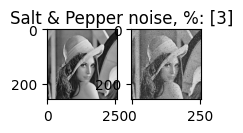

testing sigma: 3
1
testing sigma: 5
2
testing sigma: 10
3
num images 3
3
4 None None


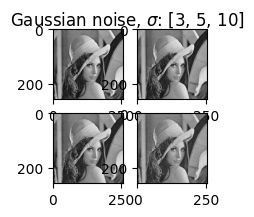

num images 6
6
7 None None


C:\Users\mihaibro\AppData\Local\Temp\ipykernel_22280\134282940.py:62: DeprecationWarning: Please import `convolve` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  return filters.convolve(im, mask)


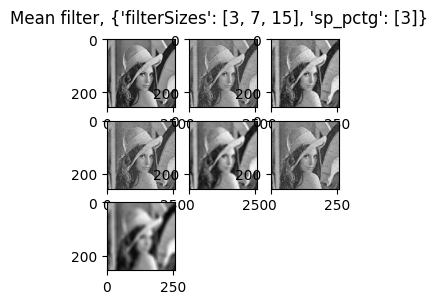

C:\Users\mihaibro\AppData\Local\Temp\ipykernel_22280\134282940.py:81: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  return filters.gaussian_filter(im, sigma)


num images 6
6
7 None None


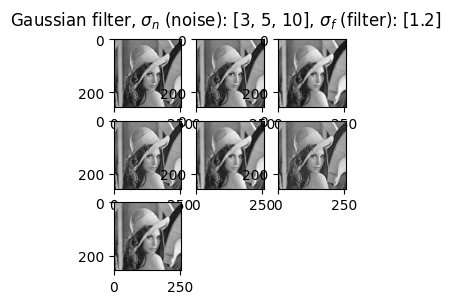

num images 6
6
7 None None


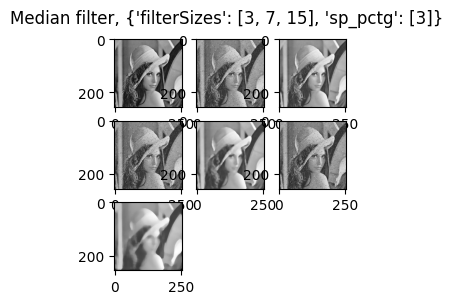

In [36]:

doTests()

## EXERCICE 1:
>Prepare a double-entry table with types of noise and types of filters. In each table cell, write how effective that filter is for that noise. Add some comments or notes about the noise level that can be considered, or which filter parameters can be adequate, and possible “side effects” over the image (e.g. maybe a given filter decreases the amount of noise but also has a negative impact on other aspects of the image). Finally, you may include additional comments highlighting the key features of each filter, or comparing among them. 


There are tests defined for some filter-noise combinations but not all of them:

| Filter | Exists With GaussianNoise | Exists With SnP noise|
|---|---|---|
|Average| NO | YES|
|Median | NO | YES|
|Gaussian|YES| NO |

So I will modify the code to account for that possibilities:

1. Define necessary methods (and refactor other methods for comprehension)

In [37]:
def testAverageFilterWithSPNoise(im_clean, params):
    imgs = []
    for sp_pctg in params['sp_pctg']:
        im_dirty = addSPNoise(im_clean, sp_pctg) # salt and pepper noise
        for filterSize in params['filterSizes']:
            imgs.append(np.array(im_dirty))
            imgs.append(averageFilter(im_dirty, filterSize))
    return imgs

def testAverageWithGaussianNoise(im_clean, params):
    # This function turned out to be too similar to testAverageFilter
    # This is a good sign that code factorization is called for :)
    imgs = []
    for sigma in params['sd_gauss_noise']:
        im_dirty = addGaussianNoise(im_clean, sigma)
        for filterSize in params['filterSizes']:
            imgs.append(np.array(im_dirty))
            imgs.append(gaussianFilter(im_dirty, filterSize))
    return imgs

def testGaussianFilterWithGaussianNoise(im_clean, params):
    # This function turned out to be too similar to testAverageFilter
    # This is a good sign that code factorization is called for :)
    imgs = []
    for sigma in params['sd_gauss_noise']:
        im_dirty = addGaussianNoise(im_clean, sigma)
        for filterSize in params['sd_gauss_filter']:
            imgs.append(np.array(im_dirty))
            imgs.append(gaussianFilter(im_dirty, filterSize))
    return imgs

def testGaussianFilterWithSPNoise(im_clean, params):
    imgs = []
    for sp_pctg in params['sp_pctg']:
        im_dirty = addSPNoise(im_clean, sp_pctg) # salt and pepper noise
        for filterSize in params['sd_gauss_filter']:
            imgs.append(np.array(im_dirty))
            imgs.append(gaussianFilter(im_dirty, filterSize))
    return imgs

def testMedianFilterWithSPNoise(im_clean, params):
    # This function turned out to be too similar to testAverageFilter
    # This is a good sign that code factorization is called for :)
    imgs = []
    for sp_pctg in params['sp_pctg']:
        im_dirty = addSPNoise(im_clean, sp_pctg)
        for filterSize in params['filterSizes']:
            imgs.append(np.array(im_dirty))
            imgs.append(medianFilter(im_dirty, filterSize))
    return imgs

def testMedianFilterWithGaussianNoise(im_clean, params):
    # This function turned out to be too similar to testAverageFilter
    # This is a good sign that code factorization is called for :)
    imgs = []
    for sigma in params['sd_gauss_noise']:
        im_dirty = addGaussianNoise(im_clean, sigma)
        for filterSize in params['filterSizes']:
            imgs.append(np.array(im_dirty))
            imgs.append(medianFilter(im_dirty, filterSize))
    return imgs

2. Redefining testing code
- Adding all new tests names to the nameTest dictionary
- Adding new tests to the `doTests()` method

In [38]:
# -----------------
# Test image files
# -----------------

path_input = './imgs-P2/'
path_output = './imgs-out-P2/'
bAllFiles = False
if bAllFiles:
    files = glob.glob(path_input + "*.pgm")
else:
    files = [path_input + 'lena256.pgm']  # lena256, lena512

# --------------------
# Tests to perform
# --------------------

testsNoises = []
testsFilters = ["testAverageFilterWithSPNoise", "testAverageWithGaussianNoise",
                "testGaussianFilterWithGaussianNoise", "testAverageFilterWithSPNoise",
                "testMedianFilterWithSPNoise", "testMedianFilterWithGaussianNoise"]
bAllTests = True
if bAllTests:
    tests = testsNoises + testsFilters
else:
    tests = ['testSandPNoise']

# -------------------------------------------------------------------
# Dictionary of user-friendly names for each function ("test") name
# -------------------------------------------------------------------

nameTests = {
    "testAverageFilterWithSPNoise":" Testing average filter with SP noise...",
    "testAverageWithGaussianNoise":"Testing average filter with Gaussian noise...",
    "testGaussianFilterWithGaussianNoise":"Testing gaussian filter with Gaussian noise...",
    "testAverageFilterWithSPNoise":"Testing average filter with SP noise...",
    "testMedianFilterWithSPNoise":"Testing median filter with SP noise...",
    "testMedianFilterWithGaussianNoise":"Testing average filter with Gaussian noise...",
    'testGaussianNoise': 'Gaussian noise',
    'testSandPNoise': 'Salt & Pepper noise'
             }

bSaveResultImgs = False

# -----------------------
# Parameters of noises
# -----------------------
percentagesSandP = [3]  # ratio (%) of image pixes affected by salt and pepper noise
gauss_sigmas_noise = [3, 5, 10]  # standard deviation (for the [0,255] range) for Gaussian noise

# -----------------------
# Parameters of filters
# -----------------------

gauss_sigmas_filter = [1.2]  # standard deviation for Gaussian filter
avgFilter_sizes = [3, 7, 15]  # sizes of mean (average) filter
medianFilter_sizes = [3, 7, 15]  # sizes of median filter

testsUsingPIL = ['testSandPNoise']  # which test(s) uses PIL images as input (instead of NumPy 2D arrays)


# -----------------------------------------
# Apply defined tests and display results
# -----------------------------------------

def doTests():
    print("Testing on", files)
    for imfile in files:
        im_pil = Image.open(imfile).convert('L')
        im = np.array(im_pil)  # from Image to array
        
        for test in tests:
            print(f"RUNNING: {test}")     
            if test == "testGaussianNoise":
                params = gauss_sigmas_noise
                subTitle = r", $\sigma$: " + str(params)
            elif test == "testSandPNoise":
                params = percentagesSandP
                subTitle = ", %: " + str(params)
            elif test == "testAverageFilterWithSPNoise":
                params = {}
                params['filterSizes'] = avgFilter_sizes
                params['sp_pctg'] = percentagesSandP
                subTitle = ", " + str(params)
            elif test == "testAverageWithGaussianNoise":
                params = {}
                params['filterSizes'] = avgFilter_sizes
                params['sd_gauss_noise'] = gauss_sigmas_noise
                subTitle = ", " + str(params)
            elif test == "testMedianFilterWithSPNoise":
                params = {}
                params['filterSizes'] = avgFilter_sizes
                params['sp_pctg'] = percentagesSandP
                subTitle = ", " + str(params)
            elif test == "testMedianFilterWithGaussianNoise":
                params = {}
                params['filterSizes'] = avgFilter_sizes
                params['sd_gauss_noise'] = gauss_sigmas_noise
                subTitle = ", " + str(params)
            elif test == "testGaussianFilterWithGaussianNoise":
                params = {}
                params['sd_gauss_noise'] = gauss_sigmas_noise
                params['sd_gauss_filter'] = gauss_sigmas_filter
                subTitle = r", $\sigma_n$ (noise): " + str(gauss_sigmas_noise) + ", $\sigma_f$ (filter): " + str(gauss_sigmas_filter)
            elif test == "testGaussianFilterWithGaussianNoise":
                params = {}
                params['sp_pctg'] = percentagesSandP
                params['sd_gauss_filter'] = gauss_sigmas_filter
                subTitle = r", $\sigma_n$ (noise): " + str(gauss_sigmas_noise) + ", $\sigma_f$ (filter): " + str(percentagesSandP)
            if test in testsUsingPIL:
                outs_pil = eval(test)(im_pil, params)
                outs_np = vpu.pil2np(outs_pil)
            else:
                # apply test to given image and given parameters
                outs_np = eval(test)(im, params)
                print("num images", len(outs_np))
            print(len(outs_np))
            # display original image, noisy images and filtered images
            vpu.showInGrid([im] + outs_np, title=nameTests[test] + subTitle)


<>:103: SyntaxWarning: invalid escape sequence '\s'
<>:108: SyntaxWarning: invalid escape sequence '\s'
<>:103: SyntaxWarning: invalid escape sequence '\s'
<>:108: SyntaxWarning: invalid escape sequence '\s'
C:\Users\mihaibro\AppData\Local\Temp\ipykernel_22280\874927217.py:103: SyntaxWarning: invalid escape sequence '\s'
  subTitle = r", $\sigma_n$ (noise): " + str(gauss_sigmas_noise) + ", $\sigma_f$ (filter): " + str(gauss_sigmas_filter)
C:\Users\mihaibro\AppData\Local\Temp\ipykernel_22280\874927217.py:108: SyntaxWarning: invalid escape sequence '\s'
  subTitle = r", $\sigma_n$ (noise): " + str(gauss_sigmas_noise) + ", $\sigma_f$ (filter): " + str(percentagesSandP)


C:\Users\mihaibro\AppData\Local\Temp\ipykernel_22280\134282940.py:62: DeprecationWarning: Please import `convolve` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  return filters.convolve(im, mask)


Testing on ['./imgs-P2/lena256.pgm']
RUNNING: testAverageFilterWithSPNoise
num images 6
6
7 None None


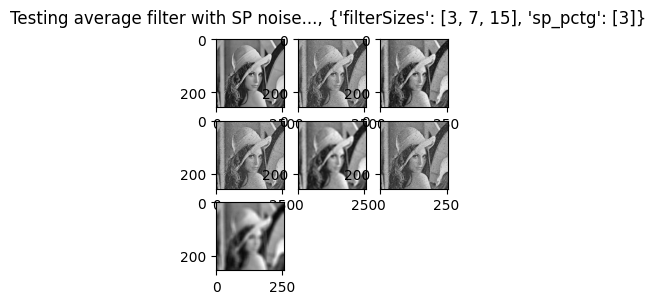

RUNNING: testAverageWithGaussianNoise
num images 18
18
19 None None


C:\Users\mihaibro\AppData\Local\Temp\ipykernel_22280\134282940.py:81: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  return filters.gaussian_filter(im, sigma)


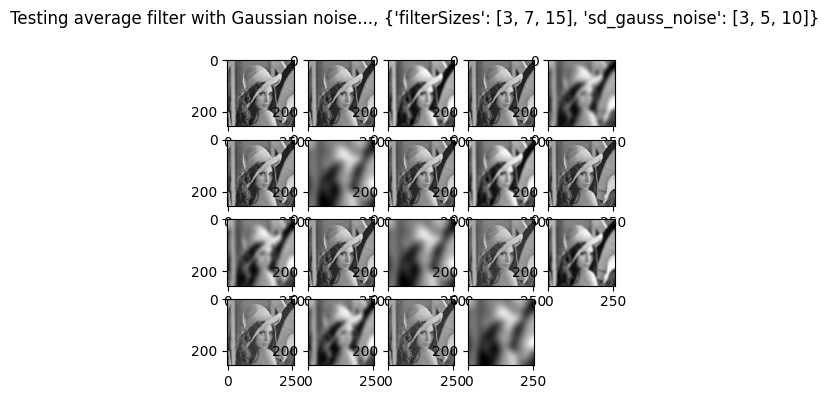

RUNNING: testGaussianFilterWithGaussianNoise
num images 6
6
7 None None


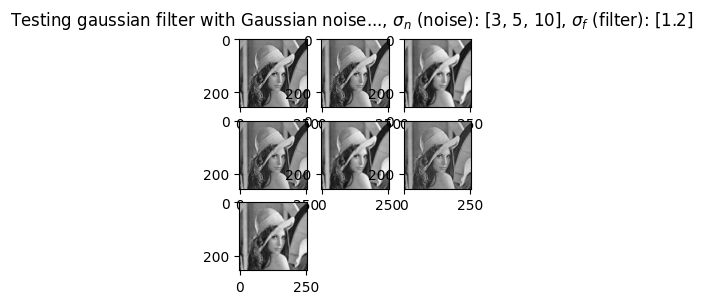

RUNNING: testAverageFilterWithSPNoise
num images 6
6
7 None None


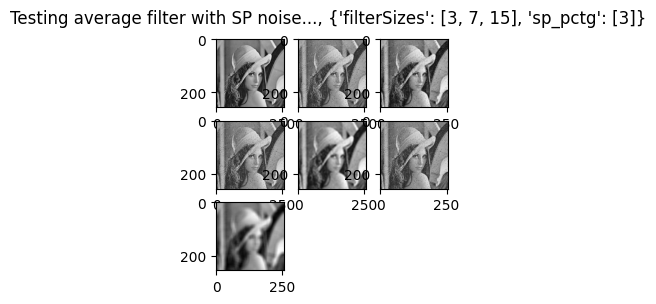

RUNNING: testMedianFilterWithSPNoise
num images 6
6
7 None None


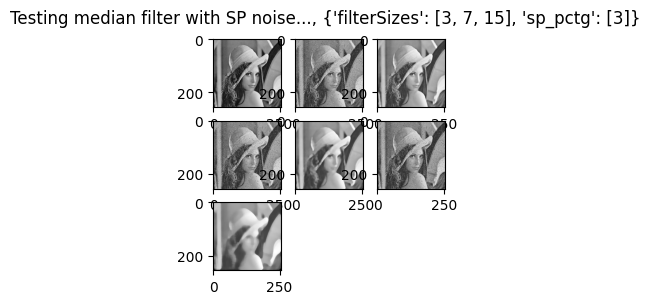

RUNNING: testMedianFilterWithGaussianNoise
num images 18
18
19 None None


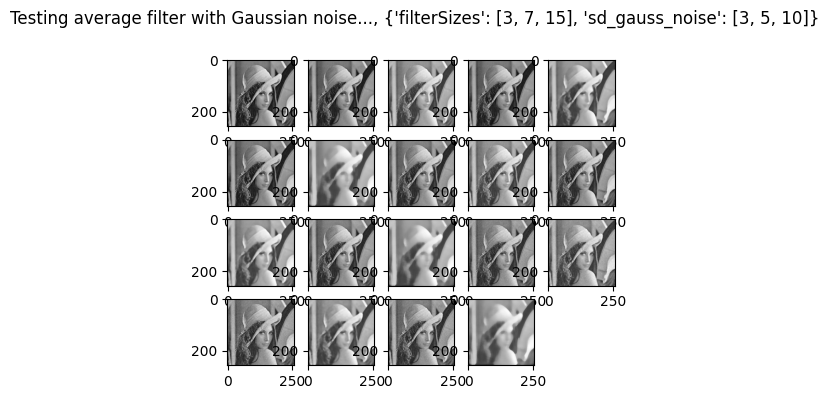

In [39]:

doTests()

### Effectiveness of each filter for each noise


| Noise Type / Filter | Gaussian Filter | Median Filter | Average Filter |
|---------------------|-----------------|---------------|----------------|
| Gaussian Noise      | Very Effective  | Moderately Effective | Effective |
| Salt and Pepper Noise | Moderately Effective | Very Effective | Less Effective |

As we have observed in the comparation between images above:

- The **Gaussian Filter** works best with **Gaussian Noise** and it is remarcably effective, especially at lower noise levels. It is also fairly effective for **SnP noise**, but not so much. Its kernel size as well as the sigma of its inner distribution are adjustable, which gives it much control over the filtration. The bigger the kernel, the better the noise suppresion (the lower the cuttoff if we understand it as a low-pass filter), but the bigger the smoothing and loss of borders.

- As for the **Median Filter**, it works best for **salt and pepper noise**, and it is less effective for **Gaussian noise**. It tends to preserve edges the best, but lose the textures of surfaces. Median works more aggressively than **Average Filters** but also the loss in texture is worse

- The **Average Filter** has is a bit of a midground; it is more effective with **gaussian noise** than **Median Filters**, but not by far so much on **salt and pepper noise**, when used on low noise levels, the results can be quite acceptable, and the computational cost is lower than the other ones. It also has more edge loss than the **median filter**


**Key points and comparation**

1. Edge preservation: median filter generally preserves edges better than Gaussian and Average filters or Gaussian ones

3. Noise level effectiveness: for low noise levels, Average or Gaussian filters might be sufficient, although for higher levels of salt and pepper noise, a Median filter is often chosen

5. Kernel size: all filters shown allow for adjusting kernel sizes and parameters of the convolution, and generally, the bigger, the lower the cutoff

## EXERCICE 2:
>As you know, the mean filter is separable. What does this imply? Well, we can obtain the same result by applying sequentially two 1D filters (one over rows and the other over columns) that by applying one 2D filter, with the benefit that the cost of applying two onedimensional filters is smaller than that of applying a single 2D filter. Write the separable version average FilterSep(), of the mean filter given in average Filter(). Check that the results are equivalent and compare the running times with increasing image and mask sizes. Plot these times using Matplotlib for a visual analysis. 

1. Defining the filter

In [40]:
def averageFilterSep(im, filterSize):
    filterX = np.ones(filterSize)
    filterX /= filterSize
    
    filtered = filters.convolve1d(im, filterX, axis=1)
    filtered = filters.convolve1d(filtered, filterX, axis=0)
    return filtered

def testAverageFilterSep(im_clean, params):
    imgs = []
    for filterSize in params['filterSizes']:
        imgs.append(averageFilterSep(im_clean, filterSize))
    return imgs

def averageFilter(im, filterSize):
    mask = np.ones((filterSize, filterSize))
    mask = np.divide(mask, np.sum(mask)) # can you think of any alternative for np.sum(mask)?
    return filters.convolve(im, mask)

def testAverageFilter(im_clean, params):
    imgs = []
    for filterSize in params['filterSizes']:
        imgs.append(averageFilter(im_clean, filterSize))
    return imgs

2. Testing

6 None None


C:\Users\mihaibro\AppData\Local\Temp\ipykernel_22280\1218110242.py:5: DeprecationWarning: Please import `convolve1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  filtered = filters.convolve1d(im, filterX, axis=1)
C:\Users\mihaibro\AppData\Local\Temp\ipykernel_22280\1218110242.py:6: DeprecationWarning: Please import `convolve1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  filtered = filters.convolve1d(filtered, filterX, axis=0)
C:\Users\mihaibro\AppData\Local\Temp\ipykernel_22280\1218110242.py:18: DeprecationWarning: Please import `convolve` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  return filters.convolve(im, mask)


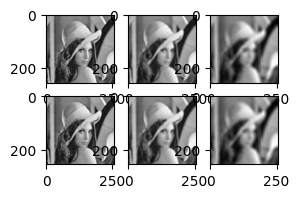

6 None None


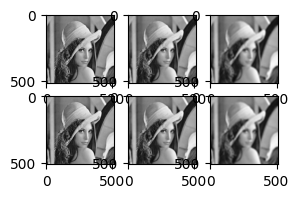

In [41]:
path_input = './imgs-P2/'
files = glob.glob(path_input + "*.pgm")
params = {}
params['filterSizes'] = [3, 7, 15]
for imfile in files:
    im_pil = Image.open(imfile).convert('L')
    im = np.array(im_pil)  # from Image to array
    outs_sep = eval("testAverageFilterSep")(im, params)
    outs_tog = eval("testAverageFilter")(im, params) # comparing with normal filter
    allOuts = outs_sep + outs_tog
    vpu.showInGrid(allOuts)
    

The results are, indeed, equivalent

3. Comparing running times
- Make a set of filter sizes ranging from 3 to about a quarter of the smaller image size (250/4)
- Run a stresstest for the 500x500 image (most time consuming image)
- Store the times for both Sep and Together filtering
- Plot

In [42]:
import time

def testAverageFilterSepExecTime(im_clean, params):
    times = []
    for filterSize in params['filterSizes']:
        print(f"TAsepTIME: {filterSize}")
        time_i = time.time()
        averageFilterSep(im_clean, filterSize)
        times.append(time.time() - time_i)
    return times

def testAverageFilterExecTime(im_clean, params):
    times = []
    for filterSize in params['filterSizes']:
        print(f"TAtogTIME: {filterSize}")
        time_i = time.time()
        averageFilter(im_clean, filterSize)
        times.append(time.time() - time_i)
    return times


In [43]:

path_input = './imgs-P2/'
im_pil = Image.open("imgs-P2/lena512.pgm").convert('L')
im_pil = np.array(im_pil)

setOfFilterSizes = np.array(range(3, im_pil.shape[0]//4, 2))

params = {}
params['filterSizes'] = list(setOfFilterSizes)

outs_sep = eval("testAverageFilterSepExecTime")(im, params)
outs_tog = eval("testAverageFilterExecTime")(im, params) # comparing with normal filter

print(setOfFilterSizes)
print(outs_sep)
print(outs_tog)



TAsepTIME: 3
TAsepTIME: 5
TAsepTIME: 7
TAsepTIME: 9
TAsepTIME: 11
TAsepTIME: 13
TAsepTIME: 15
TAsepTIME: 17
TAsepTIME: 19
TAsepTIME: 21
TAsepTIME: 23
TAsepTIME: 25
TAsepTIME: 27
TAsepTIME: 29
TAsepTIME: 31
TAsepTIME: 33
TAsepTIME: 35
TAsepTIME: 37
TAsepTIME: 39
TAsepTIME: 41
TAsepTIME: 43
TAsepTIME: 45
TAsepTIME: 47
TAsepTIME: 49
TAsepTIME: 51
TAsepTIME: 53
TAsepTIME: 55
TAsepTIME: 57
TAsepTIME: 59
TAsepTIME: 61
TAsepTIME: 63
TAsepTIME: 65
TAsepTIME: 67
TAsepTIME: 69
TAsepTIME: 71
TAsepTIME: 73
TAsepTIME: 75
TAsepTIME: 77
TAsepTIME: 79
TAsepTIME: 81
TAsepTIME: 83


C:\Users\mihaibro\AppData\Local\Temp\ipykernel_22280\1218110242.py:5: DeprecationWarning: Please import `convolve1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  filtered = filters.convolve1d(im, filterX, axis=1)
C:\Users\mihaibro\AppData\Local\Temp\ipykernel_22280\1218110242.py:6: DeprecationWarning: Please import `convolve1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  filtered = filters.convolve1d(filtered, filterX, axis=0)


TAsepTIME: 85
TAsepTIME: 87
TAsepTIME: 89
TAsepTIME: 91
TAsepTIME: 93
TAsepTIME: 95
TAsepTIME: 97
TAsepTIME: 99
TAsepTIME: 101
TAsepTIME: 103
TAsepTIME: 105
TAsepTIME: 107
TAsepTIME: 109
TAsepTIME: 111
TAsepTIME: 113
TAsepTIME: 115
TAsepTIME: 117
TAsepTIME: 119
TAsepTIME: 121
TAsepTIME: 123
TAsepTIME: 125
TAsepTIME: 127
TAtogTIME: 3
TAtogTIME: 5
TAtogTIME: 7
TAtogTIME: 9
TAtogTIME: 11
TAtogTIME: 13
TAtogTIME: 15
TAtogTIME: 17
TAtogTIME: 19


C:\Users\mihaibro\AppData\Local\Temp\ipykernel_22280\1218110242.py:18: DeprecationWarning: Please import `convolve` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  return filters.convolve(im, mask)


TAtogTIME: 21
TAtogTIME: 23
TAtogTIME: 25
TAtogTIME: 27
TAtogTIME: 29
TAtogTIME: 31
TAtogTIME: 33
TAtogTIME: 35
TAtogTIME: 37
TAtogTIME: 39
TAtogTIME: 41
TAtogTIME: 43
TAtogTIME: 45
TAtogTIME: 47
TAtogTIME: 49
TAtogTIME: 51
TAtogTIME: 53
TAtogTIME: 55
TAtogTIME: 57
TAtogTIME: 59
TAtogTIME: 61
TAtogTIME: 63
TAtogTIME: 65
TAtogTIME: 67
TAtogTIME: 69
TAtogTIME: 71
TAtogTIME: 73
TAtogTIME: 75
TAtogTIME: 77
TAtogTIME: 79
TAtogTIME: 81
TAtogTIME: 83
TAtogTIME: 85
TAtogTIME: 87
TAtogTIME: 89
TAtogTIME: 91
TAtogTIME: 93
TAtogTIME: 95
TAtogTIME: 97
TAtogTIME: 99
TAtogTIME: 101
TAtogTIME: 103
TAtogTIME: 105
TAtogTIME: 107
TAtogTIME: 109
TAtogTIME: 111
TAtogTIME: 113
TAtogTIME: 115
TAtogTIME: 117
TAtogTIME: 119
TAtogTIME: 121
TAtogTIME: 123
TAtogTIME: 125
TAtogTIME: 127
[  3   5   7   9  11  13  15  17  19  21  23  25  27  29  31  33  35  37
  39  41  43  45  47  49  51  53  55  57  59  61  63  65  67  69  71  73
  75  77  79  81  83  85  87  89  91  93  95  97  99 101 103 105 107 109
 111 113 11

<function matplotlib.pyplot.show(close=None, block=None)>

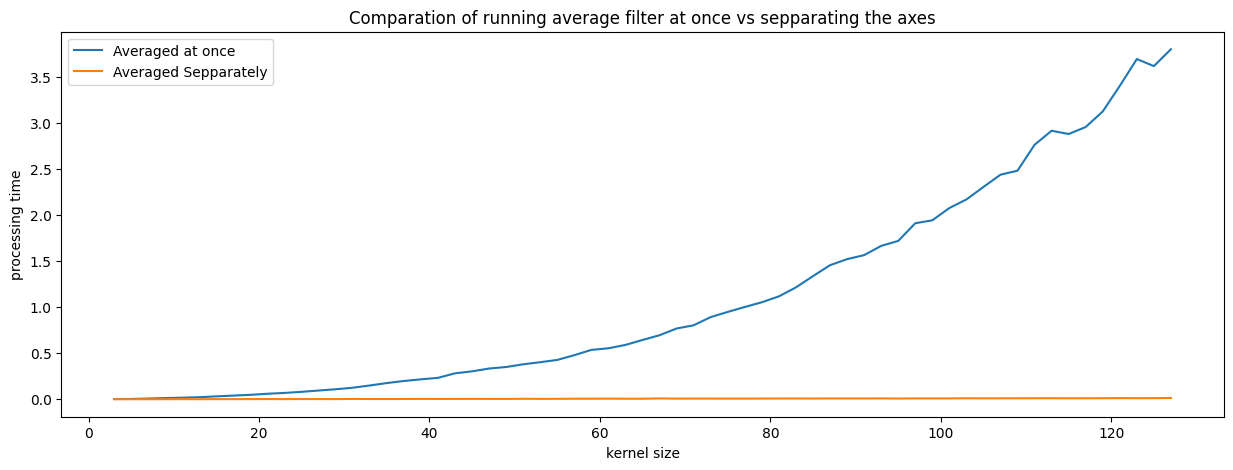

In [44]:
plt.figure(figsize=(15,5))
plt.plot(setOfFilterSizes, outs_tog, label="Averaged at once")
plt.plot(setOfFilterSizes, outs_sep, label="Averaged Sepparately")
plt.title("Comparation of running average filter at once vs sepparating the axes")
plt.xlabel("kernel size")
plt.ylabel("processing time")
plt.legend()
plt.show

As you can see, averaging sepparately is much more efficient in terms of processing time.

In [45]:
(max(outs_sep), max(outs_tog))

(0.014980554580688477, 3.8016774654388428)

## EXERCICE 3:
>In our code, we used directly the function gaussian_filter() to apply the gaussian filter. Now, we are going to do it with an explicit convolution, as we did with the mean filter, i.e. mask  creation + convolution. Let’s proceed step by step: 

>**a)** Use the function gaussian() of scipy.signal to generate an array of size n × 1 with the values of a 1D Gaussian of the given size n and standard deviation σ . Let gv1d be this vector. Display gv1d with Matplotlib, as if it was an image, without any interpolation (interpolation=’none’).

Seems like the `scipy.signal.gaussian()` method is deprecated or no longer available, so I used `scipy.stats` instead

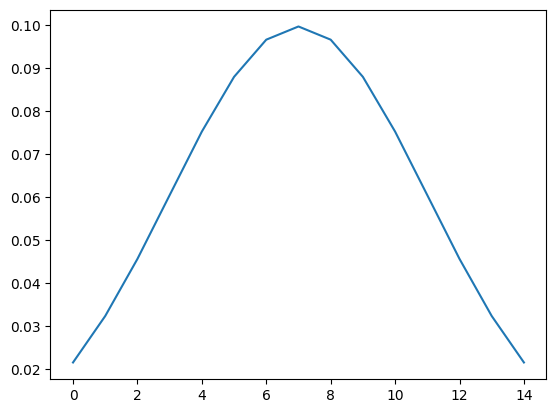

In [46]:
from scipy.stats import norm 

x_axis = np.arange(0, 15, 1) 
  
# Calculating mean and standard deviation 
mean = len(x_axis)//2
sd = 4

gv1d = norm.pdf(x_axis, mean, sd)

plt.plot(x_axis,  norm.pdf(x_axis, mean, sd)) 


>**b)** Generate an n × n matrix with the values of 2D Gaussian (as before, for the given n and σ ). Let gv2d be this matrix. You can get gv2d by a matrix product of gv1d and its transpose, either with gv1d * gv1d.T, or np.outer(gv1d, gv1d). Display gv2d as an image. Fig. 1 shows an example of both gv1d and gv2d using a color map. 

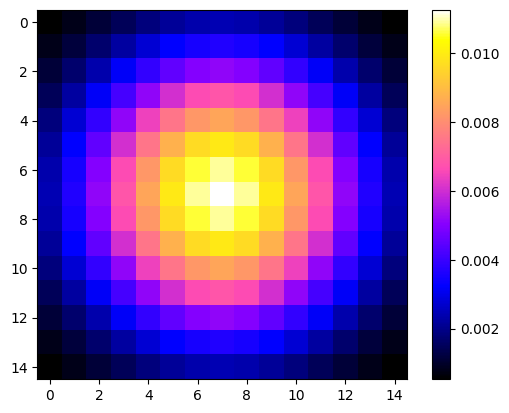

In [47]:
shape = gv1d.shape[0]
gv2d = np.repeat(gv1d, shape).reshape(shape,shape)
gv2d *= gv2d.transpose()
gv2d /= np.sum(gv2d)

plt.imshow(gv2d, cmap="gnuplot2")
plt.colorbar()
plt.show()

>**c)** Finally, use gv2d as a mask (kernel) to convolve the image to be filtered. Compare the result obtained now with that we obtained using gaussian_filter(). 

In [51]:
def gaussianFilterManual(im, window_size=15, sigma=5):
    x_axis = np.arange(0, window_size, 1)
    mean = window_size//2 
    gv2d = norm.pdf(x_axis, mean, sigma).repeat(window_size).reshape(window_size, window_size)
    gv2d = gv2d * gv2d.transpose()
    gv2d = gv2d/np.sum(gv2d)
    return filters.convolve(im, gv2d)

def testGaussianFilterManual(im_clean, params):
    # This function turned out to be too similar to testAverageFilter
    # This is a good sign that code factorization is called for :)
    imgs = []
    for filterSize in params['windowSizes']:
        imgs.append(gaussianFilterManual(im_clean, filterSize, 4))
    return imgs

C:\Users\mihaibro\AppData\Local\Temp\ipykernel_22280\1360638362.py:7: DeprecationWarning: Please import `convolve` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  return filters.convolve(im, gv2d)
C:\Users\mihaibro\AppData\Local\Temp\ipykernel_22280\134282940.py:81: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  return filters.gaussian_filter(im, sigma)


6 None None


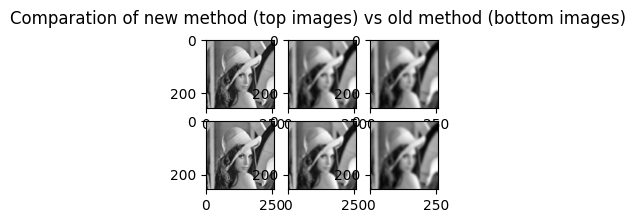

6 None None


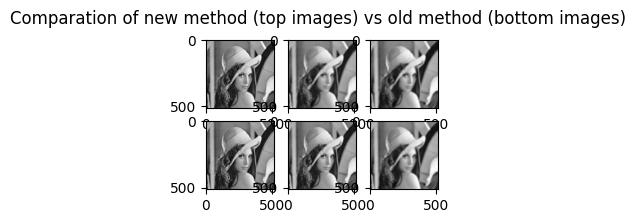

In [59]:
path_input = './imgs-P2/'
files = glob.glob(path_input + "*.pgm")
params = {}
params['windowSizes'] = [5, 15, 45]
params['sd_gauss_filter'] = [1.2, 2.5, 4]
params['sd_gauss_noise'] = [0]
for imfile in files:
    im_pil = Image.open(imfile).convert('L')
    im = np.array(im_pil)  # from Image to array
    outs_man = eval("testGaussianFilterManual")(im, params)
    outs_old = eval("testGaussianFilterWithGaussianNoise")(im, params)
    vpu.showInGrid(outs_man + [outs_old[i] for i in range(1, len(outs_old), 2)], title="Comparation of new method (top images) vs old method (bottom images)")
    

The filters are comparable (not fully because mine has both a window size and a sigma as passed parameters, sort of like in OpenCv)

>**d)** The Gaussian filter is also separable, as you know. Therefore, for the sake of efficiency, instead of applying the convolution with the 2D mask, let’s apply it with two convolutions of the 1D masks (gv1d and its transpose). Compare the result with that of the 2D convolution in the previous step.

1. Defining new method and test for it

In [67]:
def gaussianFilterManualSep(im, window_size = 15, sigma = 4):
    x_axis = np.arange(0, window_size, 1)
    mean = window_size//2 
    gv1d = norm.pdf(x_axis, mean, sigma)
    
    filtered = filters.convolve1d(im, gv1d, axis=1)
    filtered = filters.convolve1d(filtered, gv1d, axis=0)
    return filtered

def testGaussianFilterManualSep(im_clean, params):
    imgs = []
    for filterSize in params['windowSizes']:
        imgs.append(gaussianFilterManualSep(im_clean, filterSize, 4))
    return imgs

C:\Users\mihaibro\AppData\Local\Temp\ipykernel_22280\3240467579.py:6: DeprecationWarning: Please import `convolve1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  filtered = filters.convolve1d(im, gv1d, axis=1)
C:\Users\mihaibro\AppData\Local\Temp\ipykernel_22280\3240467579.py:7: DeprecationWarning: Please import `convolve1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  filtered = filters.convolve1d(filtered, gv1d, axis=0)
C:\Users\mihaibro\AppData\Local\Temp\ipykernel_22280\134282940.py:81: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  return filters.gaussian_filter(im, sigma)


6 None None


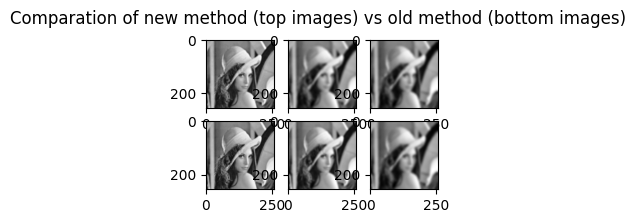

6 None None


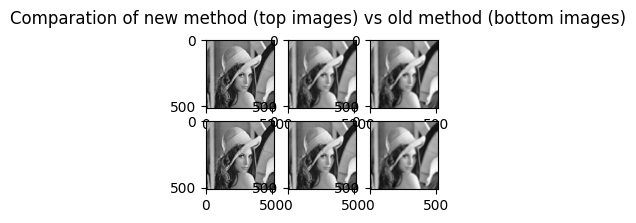

In [69]:
path_input = './imgs-P2/'
files = glob.glob(path_input + "*.pgm")
params = {}
params['windowSizes'] = [5, 15, 45]
params['sd_gauss_filter'] = [1.2, 2.5, 4]
params['sd_gauss_noise'] = [0]
for imfile in files:
    im_pil = Image.open(imfile).convert('L')
    im = np.array(im_pil)  # from Image to array
    outs_man = eval("testGaussianFilterManualSep")(im, params)
    outs_old = eval("testGaussianFilterWithGaussianNoise")(im, params)
    vpu.showInGrid(outs_man + [outs_old[i] for i in range(1, len(outs_old), 2)], title="Comparation of new method (top images) vs old method (bottom images)")
    

2. Compare the two methods changing window sizes

In [71]:
def testGaussianFilterManualSepExecTime(im_clean, params):
    times = []
    for filterSize in params['windowSizes']:
        time_i = time.time()
        gaussianFilterManualSep(im_clean, filterSize, 4)
        times.append(time.time() - time_i)
    return times

def testGaussianFilterOldExecTime(im_clean, params):
    times = []
    for filterSize in params['windowSizes']:
        time_i = time.time()
        gaussianFilter(im_clean, filterSize)
        times.append(time.time() - time_i)
    return times

In [73]:
path_input = './imgs-P2/'
im_pil = Image.open("imgs-P2/lena512.pgm").convert('L')
im_pil = np.array(im_pil)

setOfFilterSizes = np.array(range(3, im_pil.shape[0]//5, 2))

params = {}
params['windowSizes'] = list(setOfFilterSizes)

outs_sep = eval("testGaussianFilterManualSepExecTime")(im, params)
outs_tog = eval("testGaussianFilterOldExecTime")(im, params) # comparing with normal filter

print(setOfFilterSizes)
print(outs_sep)
print(outs_tog)

C:\Users\mihaibro\AppData\Local\Temp\ipykernel_22280\3240467579.py:6: DeprecationWarning: Please import `convolve1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  filtered = filters.convolve1d(im, gv1d, axis=1)
C:\Users\mihaibro\AppData\Local\Temp\ipykernel_22280\3240467579.py:7: DeprecationWarning: Please import `convolve1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  filtered = filters.convolve1d(filtered, gv1d, axis=0)
C:\Users\mihaibro\AppData\Local\Temp\ipykernel_22280\134282940.py:81: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  return filters.gaussian_filter(im, sigma)


[  3   5   7   9  11  13  15  17  19  21  23  25  27  29  31  33  35  37
  39  41  43  45  47  49  51  53  55  57  59  61  63  65  67  69  71  73
  75  77  79  81  83  85  87  89  91  93  95  97  99 101]
[0.0020253658294677734, 0.0015463829040527344, 0.002019643783569336, 0.0015342235565185547, 0.002034902572631836, 0.001993894577026367, 0.0022993087768554688, 0.0035059452056884766, 0.0035376548767089844, 0.002534151077270508, 0.003027200698852539, 0.003066539764404297, 0.0045964717864990234, 0.003995418548583984, 0.005093812942504883, 0.0035262107849121094, 0.005137920379638672, 0.0039031505584716797, 0.005323886871337891, 0.004001617431640625, 0.005181074142456055, 0.00410771369934082, 0.004403591156005859, 0.006522655487060547, 0.005572319030761719, 0.005051374435424805, 0.006006717681884766, 0.007002830505371094, 0.005560636520385742, 0.007136821746826172, 0.007117033004760742, 0.006512165069580078, 0.006542205810546875, 0.008079051971435547, 0.008450984954833984, 0.007481336593627

<function matplotlib.pyplot.show(close=None, block=None)>

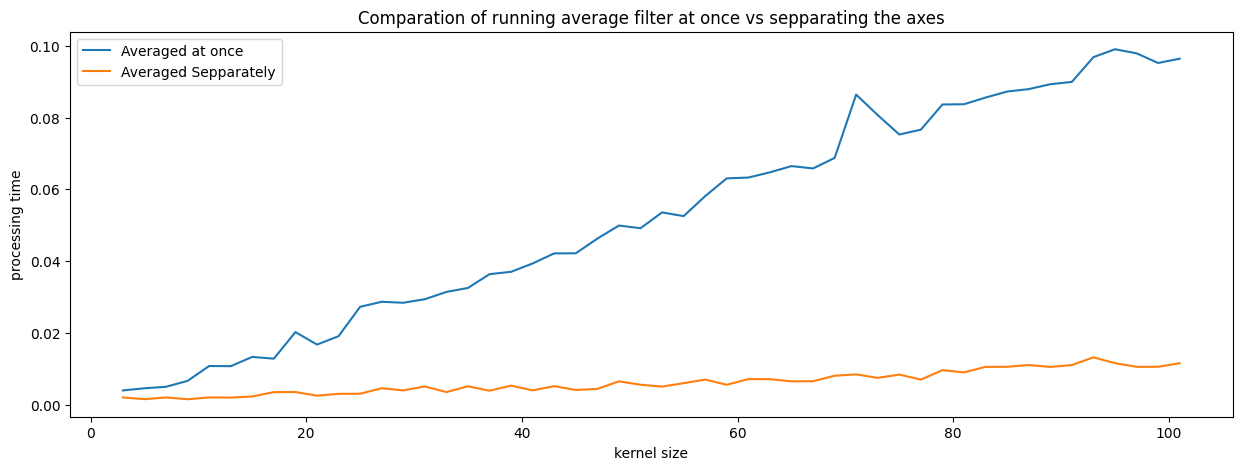

In [74]:
plt.figure(figsize=(15,5))
plt.plot(setOfFilterSizes, outs_tog, label="Averaged at once")
plt.plot(setOfFilterSizes, outs_sep, label="Averaged Sepparately")
plt.title("Comparation of running average filter at once vs sepparating the axes")
plt.xlabel("kernel size")
plt.ylabel("processing time")
plt.legend()
plt.show

## EXERCICE 4:
>Generalize the function addGaussianNoise() for it to work both for gray-level and color images. As usual, apply the filter to each of the color bands, separately. Then, find out whether this  band-wise application of the filter is actually required, and why (not).

In [96]:
def addGaussianNoise(im, sd=5):
    if len(im.shape) > 2:
        print(f"Image is multichannel n_channels = {im.shape[2]}")
        _copy = im.copy()
        for i in range(im.shape[2]):
            _copy[:,:,i] = im[:, :, i] + np.random.normal(loc=0, scale=sd, size=im.shape[:2])
        return np.array(_copy)
    
    print(f"Image is single channel")
    return im + np.random.normal(loc=0, scale=sd, size=im.shape)

2 None None


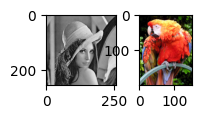

Image is single channel
Image is multichannel n_channels = 3
2 None None


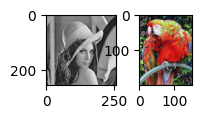

In [97]:
import requests
from io import BytesIO

image_set = []
image_set.append(np.array(Image.open("imgs-P2/lena256.pgm").convert('L')))
response = requests.get("https://upload.wikimedia.org/wikipedia/commons/d/d7/RGB_24bits_palette_sample_image.jpg")
image_set.append(np.array(Image.open(BytesIO(response.content))))
vpu.showInGrid(image_set)

images_dirty = []
for image in image_set:
    images_dirty.append(addGaussianNoise(image))

vpu.showInGrid(images_dirty)
    

<mark>Is the *band-wise* operation necessary or not? Why?</mark>

## EXERCICE 5:
>The quotient image is obtained by pixel-wise division of an image I and its blurred version I ∗Gσ , where Gσ is a 2D Gaussian kernel with standard deviation σ . Write a function quotientImage(im,sigma) that returns the quotient image for I=im with σ =sigma. Test it on some images and think of its possible usefulness. 

In [99]:
def quotientImage(im, sigma = 5):
    return im // gaussianFilter(im.copy(), sigma)

4 None None


C:\Users\mihaibro\AppData\Local\Temp\ipykernel_22280\134282940.py:81: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  return filters.gaussian_filter(im, sigma)


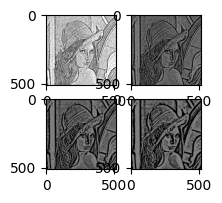

In [102]:
image = np.array(Image.open("imgs-P2/lena256.pgm").convert('L'))

sigma_list = [1.5, 3, 5, 7]

listQuotiented = []

for sigma in sigma_list:
    listQuotiented.append(quotientImage(im, sigma))

vpu.showInGrid(listQuotiented)


Might be useful for finding edges on an image